In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import torch
import tqdm
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pickle
import sklearn
import sklearn.metrics

from hydra import initialize, compose
from hydra.utils import instantiate
from typing import List, Dict, Tuple
from pathlib import Path
from pytorch_lightning.utilities import move_data_to_device
# from astropy.visualization import make_lupton_rgb
from scipy.stats import gaussian_kde

from bliss.surveys.dc2 import DC2DataModule
from bliss.catalog import TileCatalog, FullCatalog, convert_flux_to_magnitude
from bliss.encoder.encoder import Encoder
from bliss.encoder.metrics import SourceTypeAccuracy, CatalogMatcher, DetectionPerformance, SourceTypeFilter

from case_studies.dc2_cataloging.utils.safe_metric_collection import SafeMetricCollection as MetricCollection
from case_studies.dc2_cataloging.utils.bootstrap_tile_cat import bootstrap_tile_cat
from case_studies.dc2_cataloging.utils.lsst_predictor import LSSTPredictor
from case_studies.dc2_cataloging.utils.notebook_plotting_params import NoteBookPlottingParams
from case_studies.dc2_cataloging.utils.load_full_cat import get_full_cat
from case_studies.dc2_cataloging.utils.others import move_tile_cat_to_device
from case_studies.dc2_cataloging.utils.metrics import (
    DetectionRecallwrtBlendedness, 
    EllipticityResidual, 
    EllipticityResidualwrtBlendedness, 
    InBoundaryFilter, 
    OutBoundaryFilter
)


# set path
output_dir = Path("./plot_output/")
output_dir.mkdir(parents=True, exist_ok=True)

# change this model path according to your training setting
model_name = "exp_10-16-3"
encoder_name = "best_encoder.ckpt"
model_path = f"../../../bliss_output/DC2_cataloging_exp/{model_name}/checkpoints/{encoder_name}"
lsst_root_dir = "/data/scratch/dc2_nfs/"

# set device
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# load config
with initialize(config_path=".", version_base=None):
    notebook_cfg = compose("notebook_config")

# get matcher and set metric parameters
matcher: CatalogMatcher = instantiate(notebook_cfg.encoder.matcher)
bs_epochs_num = 30
base_flux_bin_cutoffs = [200, 400, 600, 800, 1000]
mag_zero_point = 3631e9
blendedness_bin_cutoffs = [0.001, 0.02, 0.1, 0.2, 0.6]
bands = ("u", "g", "r", "i", "z", "y")
tile_slen = notebook_cfg.surveys.dc2.tile_slen
boundary_width = 0.2  # for boundary performance


In [ ]:
inference_output_dir = Path("/data/scratch/pduan/notebook_output/inference/")  # don't have enough space under home directory
inference_output_dir.mkdir(exist_ok=True)

In [ ]:
batched_inference_results_file = inference_output_dir / f"{model_name}_batched_inference_results.pkl"

In [ ]:
class BatchedInferenceResults:
    def __init__(self, 
                 bliss_tile_cat_list: List[TileCatalog],
                 lsst_tile_cat_list: List[TileCatalog],
                 target_tile_cat_list: List[TileCatalog]):
        self.bliss_tile_cat_list = bliss_tile_cat_list
        self.lsst_tile_cat_list = lsst_tile_cat_list
        self.target_tile_cat_list = target_tile_cat_list
    
    def __iter__(self):
        return zip(self.bliss_tile_cat_list,
                   self.lsst_tile_cat_list,
                   self.target_tile_cat_list,
                   strict=True)

In [ ]:
def inference_for_batched_images():
    # setup bliss encoder
    tile_slen = notebook_cfg.surveys.dc2.tile_slen
    max_sources_per_tile = notebook_cfg.surveys.dc2.max_sources_per_tile
    r_band_min_flux = notebook_cfg.notebook_var.r_band_min_flux
    
    dc2: DC2DataModule = instantiate(notebook_cfg.surveys.dc2)
    dc2.setup(stage="validate")
    dc2_val_dataloader = dc2.val_dataloader()

    bliss_encoder: Encoder = instantiate(notebook_cfg.encoder).to(device=device)
    pretrained_weights = torch.load(model_path, map_location=device)["state_dict"]
    bliss_encoder.load_state_dict(pretrained_weights)
    bliss_encoder = bliss_encoder.eval()

    # setup lsst encoder
    lsst_predictor = LSSTPredictor(lsst_root_dir, r_band_min_flux, tile_slen, max_sources_per_tile)

    bliss_tile_cat_list = []
    lsst_tile_cat_list = []
    target_tile_cat_list = []
    for batch in tqdm.tqdm(dc2_val_dataloader):
        batch_on_device = move_data_to_device(batch, device=device)
        target_tile_cat = TileCatalog(batch["tile_catalog"])
        target_tile_cat = target_tile_cat.filter_by_flux(
                min_flux=r_band_min_flux,
                band=2,  # default is r band
            )
        with torch.no_grad():
            bliss_tile_cat = bliss_encoder.sample(batch_on_device, use_mode=True)
            bliss_tile_cat = bliss_tile_cat.filter_by_flux(
                min_flux=r_band_min_flux,
                band=2,
            )
        target_tile_cat_list.append(move_tile_cat_to_device(target_tile_cat, device="cpu"))
        bliss_tile_cat_list.append(move_tile_cat_to_device(bliss_tile_cat, device="cpu"))
        
        wcs_header_str_list = batch["wcs_header_str"]
        image_lim = batch["images"].shape[2]
        height_index_list = batch["image_height_index"].tolist()
        width_index_list = batch["image_width_index"].tolist()
        lsst_tile_cat = lsst_predictor.predict(wcs_header_str_list, 
                                                image_lim, 
                                                height_index_list, 
                                                width_index_list)
        lsst_tile_cat_list.append(lsst_tile_cat)
    
    return BatchedInferenceResults(bliss_tile_cat_list,
                                    lsst_tile_cat_list,
                                    target_tile_cat_list)

In [ ]:
if not batched_inference_results_file.exists():
    print(f"can't find {batched_inference_results_file}, and try to generate it", flush=True)
    batched_inference_results = inference_for_batched_images()
    with open(batched_inference_results_file, "wb") as f:
        pickle.dump(batched_inference_results, f, pickle.HIGHEST_PROTOCOL)
else:
    print(f"find {batched_inference_results_file}, and directly use it", flush=True)
    with open(batched_inference_results_file, "rb") as f:
        batched_inference_results = pickle.load(f)

In [ ]:
bs_results_file = inference_output_dir / f"{model_name}_bs_results.pkl"

In [ ]:
class BSResults:
    def __init__(self, 
                 bs_epochs_num: int,
                 bliss_full_cat_bs_list: List[List[FullCatalog]],
                 lsst_full_cat_bs_list: List[List[FullCatalog]],
                 target_full_cat_bs_list: List[List[FullCatalog]],
                 bliss_matching_bs_list: List[List[List[Tuple[torch.Tensor, torch.Tensor]]]],
                 lsst_matching_bs_list: List[List[List[Tuple[torch.Tensor, torch.Tensor]]]]):
        self.bs_epochs_num = bs_epochs_num
        self.bliss_full_cat_bs_list = bliss_full_cat_bs_list
        self.lsst_full_cat_bs_list = lsst_full_cat_bs_list
        self.target_full_cat_bs_list = target_full_cat_bs_list
        self.bliss_matching_bs_list = bliss_matching_bs_list
        self.lsst_matching_bs_list = lsst_matching_bs_list

    def __iter__(self):
        for epoch in range(self.bs_epochs_num):
            yield (epoch, 
                   zip(self.bliss_full_cat_bs_list[epoch],
                       self.lsst_full_cat_bs_list[epoch],
                       self.target_full_cat_bs_list[epoch],
                       self.bliss_matching_bs_list[epoch],
                       self.lsst_matching_bs_list[epoch],
                       strict=True),
                )

In [ ]:
class BSResults:
    def __init__(self, 
                 bs_epochs_num: int,
                 bliss_full_cat_bs_list: List[List[FullCatalog]],
                 lsst_full_cat_bs_list: List[List[FullCatalog]],
                 target_full_cat_bs_list: List[List[FullCatalog]],
                 bliss_matching_bs_list: List[List[List[Tuple[torch.Tensor, torch.Tensor]]]],
                 lsst_matching_bs_list: List[List[List[Tuple[torch.Tensor, torch.Tensor]]]]):
        self.bs_epochs_num = bs_epochs_num
        self.bliss_full_cat_bs_list = bliss_full_cat_bs_list
        self.lsst_full_cat_bs_list = lsst_full_cat_bs_list
        self.target_full_cat_bs_list = target_full_cat_bs_list
        self.bliss_matching_bs_list = bliss_matching_bs_list
        self.lsst_matching_bs_list = lsst_matching_bs_list

    def __iter__(self):
        for epoch in range(self.bs_epochs_num):
            yield (epoch, 
                   zip(self.bliss_full_cat_bs_list[epoch],
                       self.lsst_full_cat_bs_list[epoch],
                       self.target_full_cat_bs_list[epoch],
                       self.bliss_matching_bs_list[epoch],
                       self.lsst_matching_bs_list[epoch],
                       strict=True),
                )

In [ ]:
def bootstrap_inference(batched_inference_results: BatchedInferenceResults):
    tile_slen = notebook_cfg.surveys.dc2.tile_slen

    bliss_full_cat_bs_list = []
    lsst_full_cat_bs_list = []
    target_full_cat_bs_list = []
    bliss_matching_bs_list = []
    lsst_matching_bs_list = []

    for epoch in range(bs_epochs_num):
        print(f"Epoch: {epoch}")
        seed = random.randint(1e4, 1e5 - 1)
        bliss_full_cat_bs_list.append([])
        lsst_full_cat_bs_list.append([])
        target_full_cat_bs_list.append([])
        bliss_matching_bs_list.append([])
        lsst_matching_bs_list.append([])
        for bliss_tile_cat, lsst_tile_cat, target_tile_cat in tqdm.tqdm(batched_inference_results):
            bliss_full_cat = bootstrap_tile_cat(bliss_tile_cat, seed=seed).to_full_catalog(tile_slen)
            lsst_full_cat = bootstrap_tile_cat(lsst_tile_cat, seed=seed).to_full_catalog(tile_slen)
            target_full_cat = bootstrap_tile_cat(target_tile_cat, seed=seed).to_full_catalog(tile_slen)
            bliss_full_cat_bs_list[epoch].append(bliss_full_cat)
            lsst_full_cat_bs_list[epoch].append(lsst_full_cat)
            target_full_cat_bs_list[epoch].append(target_full_cat)

            bliss_matching = matcher.match_catalogs(target_full_cat, bliss_full_cat)
            lsst_matching = matcher.match_catalogs(target_full_cat, lsst_full_cat)
            bliss_matching_bs_list[epoch].append(bliss_matching)
            lsst_matching_bs_list[epoch].append(lsst_matching)

    return BSResults(bs_epochs_num,
                     bliss_full_cat_bs_list,
                     lsst_full_cat_bs_list,
                     target_full_cat_bs_list,
                     bliss_matching_bs_list,
                     lsst_matching_bs_list)

In [ ]:
if not bs_results_file.exists():
    print(f"can't find {bs_results_file}, and try to generate it", flush=True)
    bs_results = bootstrap_inference(batched_inference_results)
    with open(bs_results_file, "wb") as f:
        pickle.dump(bs_results, f, pickle.HIGHEST_PROTOCOL)
else:
    print(f"find {bs_results_file}, and directly use it", flush=True)
    with open(bs_results_file, "rb") as f:
        bs_results = pickle.load(f)

In [ ]:
detection_bs_output_dir = output_dir / "detection_bs"
detection_bs_output_dir.mkdir(exist_ok=True)

In [50]:
class DetectionBSPlotting:
    def __init__(self, 
                 s_1_bliss_is: Dict[str, torch.Tensor],
                 s_1_lsst_is: Dict[str, torch.Tensor],
                 s_3_bliss_is: Dict[str, torch.Tensor],
                 s_3_lsst_is: Dict[str, torch.Tensor],
                 s_5_bliss_is: Dict[str, torch.Tensor],
                 s_5_lsst_is: Dict[str, torch.Tensor],
                 bin_cutoffs: torch.Tensor):
        self.quantile_points = torch.tensor([0.05, 0.5, 0.95])
        self.s_1_bliss_is = s_1_bliss_is
        self.s_1_lsst_is = s_1_lsst_is
        self.s_3_bliss_is = s_3_bliss_is
        self.s_3_lsst_is = s_3_lsst_is
        self.s_5_bliss_is = s_5_bliss_is
        self.s_5_lsst_is = s_5_lsst_is
        self.xlabels = (
            [f"< {bin_cutoffs[0]:.1f}"]
            + [f"[{bin_cutoffs[i]:.1f}, {bin_cutoffs[i + 1]:.1f}]" for i in range(len(bin_cutoffs) - 1)]
            + [f"[{bin_cutoffs[-1]:.1f}, 26.4]"]
        )

    def get_recall_precision_f1(self, metric_is: Dict[str, torch.Tensor]):
        recall_list = (metric_is["n_true_matches"] / metric_is["n_true_sources"]).nan_to_num(0)
        recall_matrix = recall_list.quantile(q=self.quantile_points, dim=0)
        precision_list = (metric_is["n_est_matches"] / metric_is["n_est_sources"]).nan_to_num(0)
        precision_matrix = precision_list.quantile(q=self.quantile_points, dim=0)
        f1_list = (2 * precision_list * recall_list / (precision_list + recall_list)).nan_to_num(0)
        f1_matrix = f1_list.quantile(q=self.quantile_points, dim=0)
        return recall_matrix, precision_matrix, f1_matrix

    def _plot_for_one_col(self, 
                          col_axes: List[plt.Axes], 
                          bliss_is: Dict[str, torch.Tensor], 
                          lsst_is: Dict[str, torch.Tensor],
                          show_legend: bool,
                          slack: int):
        x = np.array(list(range(len(self.xlabels))))
        bar_width = 0.3

        bliss_r_m, bliss_p_m, bliss_f_m = self.get_recall_precision_f1(bliss_is)
        lsst_r_m, lsst_p_m, lsst_f_m = self.get_recall_precision_f1(lsst_is)

        col_axes[0].bar(
            x - bar_width,
            bliss_is["n_est_sources"].mean(dim=0).tolist(),
            bar_width,
            label="BLISS",
            color=NoteBookPlottingParams.color_dict["bliss"],
        )
        col_axes[0].bar(
            x,
            lsst_is["n_est_sources"].mean(dim=0).tolist(),
            bar_width,
            label="LSST",
            color=NoteBookPlottingParams.color_dict["lsst"],
        )
        col_axes[0].bar(
            x + bar_width,
            bliss_is["n_true_sources"].mean(dim=0).tolist(),
            bar_width,
            label="ground truth",
            color=NoteBookPlottingParams.color_dict["detection_bar_plot"]["ground_truth"],
        )
    
        count_max = max(bliss_is[f"n_est_sources"].max().item(),
                        lsst_is[f"n_est_sources"].max().item(),
                        bliss_is["n_true_sources"].max().item())
        count_ticks = np.round(np.linspace(0, count_max, 5), -3)
        col_axes[0].set_yticks(count_ticks)
        col_axes[0].tick_params(labelsize=NoteBookPlottingParams.fontsize)
        col_axes[0].set_ylabel("# of detections or \n ground truth", fontsize=NoteBookPlottingParams.fontsize)
        if show_legend:
            col_axes[0].legend(fontsize=NoteBookPlottingParams.fontsize)
        col_axes[0].grid(visible=True, axis="y")
        col_axes[0].grid(visible=False, axis="x")
        if slack > 1:
            col_axes[0].set_title(f"Matching Threshold: {slack} pixels", fontsize=NoteBookPlottingParams.fontsize)
        else:
            col_axes[0].set_title(f"Matching Threshold: {slack} pixel", fontsize=NoteBookPlottingParams.fontsize)


        col_axes[1].plot(
            x,
            bliss_p_m[1, :],
            "-o",
            color=NoteBookPlottingParams.color_dict["bliss"],
            label="BLISS",
        )
        col_axes[1].fill_between(
            x,
            bliss_p_m[0, :],
            bliss_p_m[2, :],
            color=NoteBookPlottingParams.color_dict["bliss"],
            alpha=0.5,
        )
        col_axes[1].plot(
            x,
            lsst_p_m[1, :],
            "-o",
            color=NoteBookPlottingParams.color_dict["lsst"],
            label="LSST",
        )
        col_axes[1].fill_between(
            x,
            lsst_p_m[0, :],
            lsst_p_m[2, :],
            color=NoteBookPlottingParams.color_dict["lsst"],
            alpha=0.5,
        )
        # col_axes[1].set_xlabel("R-Band Magnitude", fontsize=NoteBookPlottingParams.fontsize)
        col_axes[1].set_xticks(range(len(self.xlabels)))
        col_axes[1].set_xticklabels(self.xlabels, rotation=45)
        col_axes[1].tick_params(labelsize=NoteBookPlottingParams.fontsize)
        col_axes[1].set_ylim(bottom=0.5, top=1.0)
        col_axes[1].set_ylabel("Precision", fontsize=NoteBookPlottingParams.fontsize)
        if show_legend:
            col_axes[1].legend(fontsize=NoteBookPlottingParams.fontsize)
        col_axes[1].grid(visible=True, axis="y")
        col_axes[1].grid(visible=False, axis="x")


        col_axes[2].plot(
            x,
            bliss_r_m[1, :],
            "-o",
            color=NoteBookPlottingParams.color_dict["bliss"],
            label="BLISS",
        )
        col_axes[2].fill_between(
            x,
            bliss_r_m[0, :],
            bliss_r_m[2, :],
            color=NoteBookPlottingParams.color_dict["bliss"],
            alpha=0.5,
        )
        col_axes[2].plot(
            x,
            lsst_r_m[1, :],
            "-o",
            color=NoteBookPlottingParams.color_dict["lsst"],
            label="LSST",
        )
        col_axes[2].fill_between(
            x,
            lsst_r_m[0, :],
            lsst_r_m[2, :],
            color=NoteBookPlottingParams.color_dict["lsst"],
            alpha=0.5,
        )
        col_axes[2].set_xlabel("R-Band Magnitude", fontsize=NoteBookPlottingParams.fontsize)
        col_axes[2].set_xticks(x)
        col_axes[2].set_xticklabels(self.xlabels, rotation=45)
        col_axes[2].tick_params(labelsize=NoteBookPlottingParams.fontsize)
        col_axes[2].set_ylim(bottom=0.5, top=1.0)
        col_axes[2].set_ylabel("Recall", fontsize=NoteBookPlottingParams.fontsize)
        if show_legend:
            col_axes[2].legend(fontsize=NoteBookPlottingParams.fontsize)
        col_axes[2].grid(visible=True, axis="y")
        col_axes[2].grid(visible=False, axis="x")

    def plot(self):
        fig, axes = plt.subplots(
            3, 3, 
            figsize=(NoteBookPlottingParams.figsize[0] * 4, 
                     NoteBookPlottingParams.figsize[1] * 2.5), 
            gridspec_kw={"height_ratios": [2, 3, 3]}, 
            sharex="col"
        )
        
        self._plot_for_one_col(axes[:, 0], self.s_1_bliss_is, self.s_1_lsst_is, show_legend=True, slack=1)
        self._plot_for_one_col(axes[:, 1], self.s_3_bliss_is, self.s_3_lsst_is, show_legend=False, slack=3)
        self._plot_for_one_col(axes[:, 2], self.s_5_bliss_is, self.s_5_lsst_is, show_legend=False, slack=5)

        fig.tight_layout()
        
        return fig

In [ ]:
def get_detection_internal_state(matcher_slack: int):
    bliss_metrics = MetricCollection({
        "detection_performance": DetectionPerformance(base_flux_bin_cutoffs=base_flux_bin_cutoffs,
                                                      mag_zero_point=mag_zero_point,
                                                      report_bin_unit="mag"),
    })
    lsst_metrics = bliss_metrics.clone()

    bliss_metric_internal_states = {}
    lsst_metric_internal_states = {}

    my_matcher = CatalogMatcher(dist_slack=matcher_slack)
    for epoch, results in bs_results:
        print(f"[Epoch: {epoch}; Slack: {matcher_slack}]")
        for bliss_full_cat, lsst_full_cat, target_full_cat, _bliss_matching, _lsst_matching in tqdm.tqdm(results):
            bliss_matching = my_matcher.match_catalogs(target_full_cat, bliss_full_cat)
            lsst_matching = my_matcher.match_catalogs(target_full_cat, lsst_full_cat)
            bliss_metrics.update(target_full_cat, bliss_full_cat, bliss_matching)
            lsst_metrics.update(target_full_cat, lsst_full_cat, lsst_matching)

        for k, v in bliss_metrics.items():
            internal_states = v.get_internal_states()
            for k_state, v_state in internal_states.items():
                if k_state not in bliss_metric_internal_states:
                    bliss_metric_internal_states[k_state] = []
                bliss_metric_internal_states[k_state].append(v_state)

        for k, v in lsst_metrics.items():
            internal_states = v.get_internal_states()
            for k_state, v_state in internal_states.items():
                if k_state not in lsst_metric_internal_states:
                    lsst_metric_internal_states[k_state] = []
                lsst_metric_internal_states[k_state].append(v_state)

        bliss_metrics.reset()
        lsst_metrics.reset()

    bliss_metric_internal_states = {k: torch.stack(v) for k, v in bliss_metric_internal_states.items()}
    lsst_metric_internal_states = {k: torch.stack(v) for k, v in lsst_metric_internal_states.items()}

    return bliss_metric_internal_states, lsst_metric_internal_states, bliss_metrics["detection_performance"].get_report_bins()

In [ ]:
slack_1_bliss_inter_s, slack_1_lsst_inter_s, report_bins = get_detection_internal_state(matcher_slack=1)
slack_3_bliss_inter_s, slack_3_lsst_inter_s, _report_bins = get_detection_internal_state(matcher_slack=3)
slack_5_bliss_inter_s, slack_5_lsst_inter_s, _report_bins = get_detection_internal_state(matcher_slack=5)

In [53]:
torch.save({
    "slack_1_bliss_inter_s": slack_1_bliss_inter_s,
    "slack_1_lsst_inter_s": slack_1_lsst_inter_s,
    "slack_3_bliss_inter_s": slack_3_bliss_inter_s,
    "slack_3_lsst_inter_s": slack_3_lsst_inter_s,
    "slack_5_bliss_inter_s": slack_5_bliss_inter_s,
    "slack_5_lsst_inter_s": slack_5_lsst_inter_s,
}, inference_output_dir / "diff_match.pkl")

In [51]:
NoteBookPlottingParams.fontsize = 8 * 1.5
detection_bs_plotting = DetectionBSPlotting(slack_1_bliss_inter_s,
                               slack_1_lsst_inter_s,
                               slack_3_bliss_inter_s,
                               slack_3_lsst_inter_s,
                               slack_5_bliss_inter_s,
                               slack_5_lsst_inter_s,
                               report_bins)

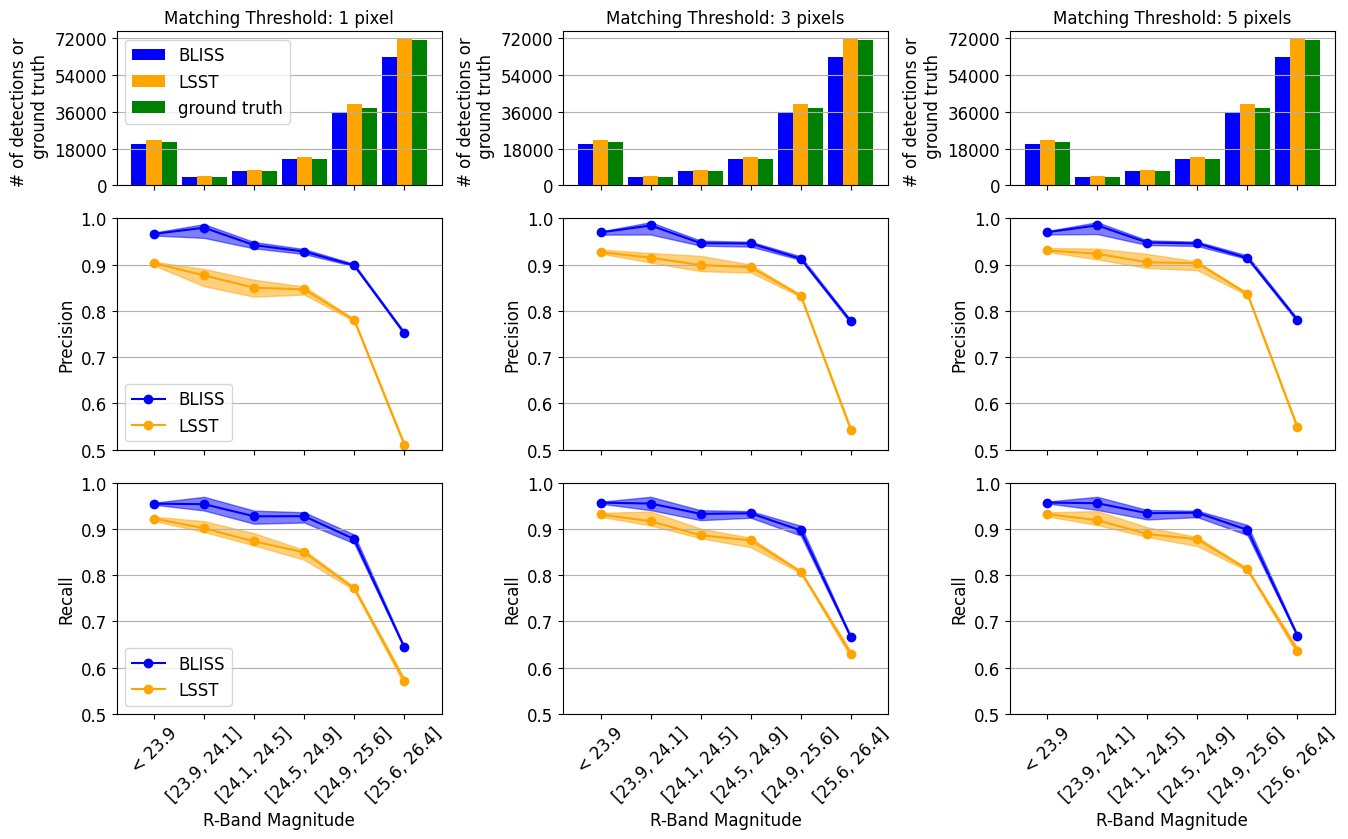

In [52]:
fig = detection_bs_plotting.plot()
fig.savefig(detection_bs_output_dir / "diff_match.pdf", 
            bbox_inches="tight", dpi=NoteBookPlottingParams.dpi)
fig.show()